In [1]:
!pip install fastai2

     |████████████████████████████████| 184kB 9.5MB/s 


# Image classification

## From dogs and cats, to pet breeds

In [2]:
from fastai2.vision.all import *
path = untar_data(URLs.PETS)

In [3]:
fname = (path/"images").ls()[0]; fname

Path('/root/.fastai/data/oxford-iiit-pet/images/german_shorthaired_25.jpg')

In [4]:
re.findall(r'(.+)_\d+.jpg$', fname.name)

['german_shorthaired']

In [0]:
pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

In [6]:
pets.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/shiba_inu_36.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=375x500
  Pipeline: partial -> Categorize
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/shiba_inu_36.jpg
    applying partial gives
      shiba_inu
    applying Categorize gives
      TensorCategory(33)

Final sample: (PILImage mode=RGB size=375x500, TensorCategory(33))


Setting up after_item: Pipeline: Resize -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -> AffineCoordTfm -> RandomResizedCropGPU -> LightingTfm

Building one batch
Applying item_tfms to the first sample:
  Pipeline: Resize -> ToTensor
    starting from
      (PILImage mode=RGB size=375x500, Tensor

## Presizing

In [7]:
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
dls1.train.get_idxs = lambda: Inf.ones
x,y = dls1.valid.one_batch()
_,axs = subplots(1, 2)

x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

FileNotFoundError: ignored

### Checking and debugging a DataBlock

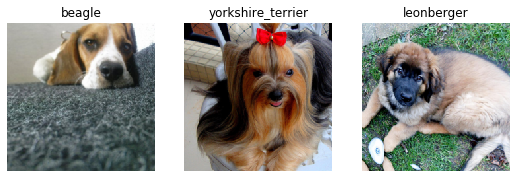

In [0]:
dls.show_batch(nrows=1, ncols=3)

In [0]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'))
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize

Building one sample
  Pipeline: PILBase.create
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x414
  Pipeline: partial -> Categorize
    starting from
      /home/jhoward/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_31.jpg
    applying partial gives
      american_pit_bull_terrier
    applying Categorize gives
      TensorCategory(13)

Final sample: (PILImage mode=RGB size=500x414, TensorCategory(13))


Setting up after_item: Pipeline: ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor

Building one batch
Applying item_tfms to the first sample:
  Pipeline: ToTensor
    starting from
      (PILImage mode=RGB size=500x414, TensorCategory(13))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 414 and 375 in dimension 2 at /opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/TH/generic/THTensor.cpp:612

In [11]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.509536,0.340732,0.116373,01:00


epoch,train_loss,valid_loss,error_rate,time
0,0.507345,0.276489,0.093369,01:01
1,0.314025,0.254352,0.083897,01:01


## Cross entropy loss

### Viewing activations and labels

In [0]:
x,y = dls.one_batch()

In [15]:
x.shape

torch.Size([64, 3, 224, 224])

In [9]:
y

TensorCategory([36, 29, 13,  3, 30, 28,  4,  4,  3,  6, 10, 26, 25, 33, 19, 15, 14, 33,
        12, 26, 16, 35, 22, 15, 26, 19, 11, 30, 32, 24, 22,  8, 25, 36,  8, 24,
        28, 17, 13, 35, 36, 33,  6,  1, 31,  8, 30, 35, 24, 24, 11, 36,  0, 28,
        20,  6, 12, 22, 24, 28, 16, 12,  3, 11], device='cuda:0')

In [13]:
learn.get_preds(dl=[(x,y)])

torch.Size([64, 37])

In [0]:
preds,_ = learn.get_preds(dl=[(x,y)])
preds[0]

tensor([7.9069e-04, 6.2350e-05, 3.7607e-05, 2.9260e-06, 1.3032e-05, 2.5760e-05, 6.2341e-08, 3.6400e-07, 4.1311e-06, 1.3310e-04, 2.3090e-03, 9.9281e-01, 4.6494e-05, 6.4266e-07, 1.9780e-06, 5.7005e-07,
        3.3448e-06, 3.5691e-03, 3.4385e-06, 1.1578e-05, 1.5916e-06, 8.5567e-08, 5.0773e-08, 2.2978e-06, 1.4150e-06, 3.5459e-07, 1.4599e-04, 5.6198e-08, 3.4108e-07, 2.0813e-06, 8.0568e-07, 4.3381e-07,
        1.0069e-05, 9.1020e-07, 4.8714e-06, 1.2734e-06, 2.4735e-06])

In [0]:
len(preds[0]),preds[0].sum()

(37, tensor(1.0000))

### Softmax

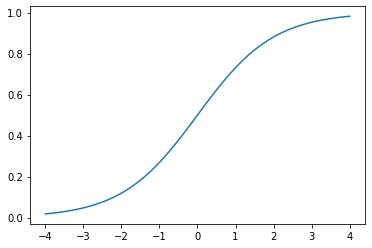

In [0]:
plot_function(torch.sigmoid, min=-4,max=4)

In [0]:
#hide
torch.random.manual_seed(42);

In [0]:
acts = torch.randn((6,2))*2
acts

tensor([[ 0.6734,  0.2576],
        [ 0.4689,  0.4607],
        [-2.2457, -0.3727],
        [ 4.4164, -1.2760],
        [ 0.9233,  0.5347],
        [ 1.0698,  1.6187]])

In [0]:
acts.sigmoid()

tensor([[0.6623, 0.5641],
        [0.6151, 0.6132],
        [0.0957, 0.4079],
        [0.9881, 0.2182],
        [0.7157, 0.6306],
        [0.7446, 0.8346]])

In [0]:
(acts[:,0]-acts[:,1]).sigmoid()

tensor([0.6025, 0.5021, 0.1332, 0.9966, 0.5959, 0.3661])

In [0]:
sm_acts = torch.softmax(acts, dim=1)
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

### Log likelihood

In [0]:
targ = tensor([0,1,0,1,1,0])

In [0]:
sm_acts

tensor([[0.6025, 0.3975],
        [0.5021, 0.4979],
        [0.1332, 0.8668],
        [0.9966, 0.0034],
        [0.5959, 0.4041],
        [0.3661, 0.6339]])

In [0]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.6025, 0.4979, 0.1332, 0.0034, 0.4041, 0.3661])

In [0]:
from IPython.display import HTML
df = pd.DataFrame(sm_acts, columns=["3","7"])
df['targ'] = targ
df['idx'] = idx
df['loss'] = sm_acts[range(6), targ]
t = df.style.hide_index()
#To have html code compatible with our script
html = t._repr_html_().split('</style>')[1]
html = re.sub(r'<table id="([^"]+)"\s*>', r'<table >', html)
display(HTML(html))

3,7,targ,idx,loss
0.602469,0.397531,0,0,0.602469
0.502065,0.497935,1,1,0.497935
0.133188,0.866811,0,2,0.133188
0.99664,0.00336017,1,3,0.00336017
0.595949,0.404051,1,4,0.404051
0.366118,0.633882,0,5,0.366118


In [0]:
-sm_acts[idx, targ]

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

In [0]:
F.nll_loss(sm_acts, targ, reduction='none')

tensor([-0.6025, -0.4979, -0.1332, -0.0034, -0.4041, -0.3661])

### Taking the `log`

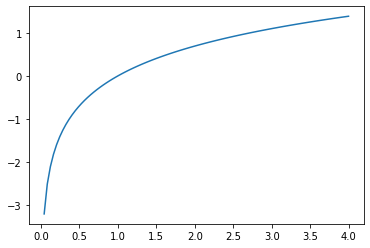

In [0]:
plot_function(torch.log, min=0,max=4)

In [0]:
loss_func = nn.CrossEntropyLoss()

In [0]:
loss_func(acts, targ)

tensor(1.8045)

In [0]:
F.cross_entropy(acts, targ)

tensor(1.8045)

In [0]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([0.5067, 0.6973, 2.0160, 5.6958, 0.9062, 1.0048])

## Model Interpretation

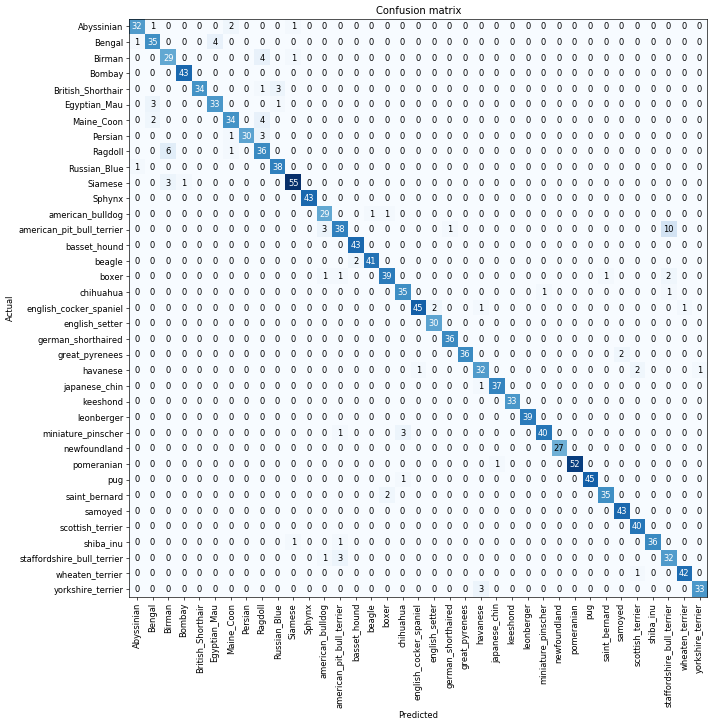

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [0]:
interp.most_confused(min_val=5)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 10),
 ('Ragdoll', 'Birman', 6)]

## Improving our model

### Learning rate finder

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,8.946717,47.954632,0.893775,00:20


epoch,train_loss,valid_loss,error_rate,time
0,7.231843,4.119265,0.954668,00:24


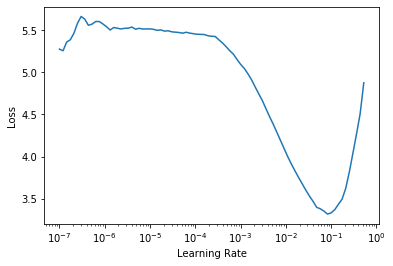

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find()

In [0]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

Minimum/10: 8.32e-03, steepest point: 6.31e-03


In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.071820,0.427476,0.133965,00:19


epoch,train_loss,valid_loss,error_rate,time
0,0.738273,0.541828,0.150880,00:24
1,0.401544,0.266623,0.081867,00:24


### Unfreezing and transfer learning

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.188042,0.355024,0.102842,00:20
1,0.534234,0.302453,0.094723,00:20
2,0.325031,0.222268,0.074425,00:20


In [0]:
learn.unfreeze()

(1.0964782268274575e-05, 1.5848931980144698e-06)

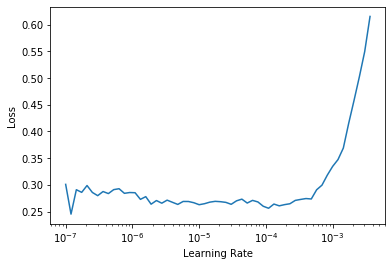

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.263579,0.217419,0.069012,00:24
1,0.253060,0.210346,0.062923,00:24
2,0.224340,0.207357,0.060217,00:24
3,0.200195,0.207244,0.061570,00:24
4,0.194269,0.200149,0.059540,00:25
5,0.173164,0.202301,0.059540,00:25


### Discriminative learning rates

In [0]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,1.145300,0.345568,0.119756,00:20
1,0.533986,0.251944,0.077131,00:20
2,0.317696,0.208371,0.069012,00:20


epoch,train_loss,valid_loss,error_rate,time
0,0.257977,0.205400,0.067659,00:25
1,0.246763,0.205107,0.066306,00:25
2,0.240595,0.193848,0.062246,00:25
3,0.209988,0.198061,0.062923,00:25
4,0.194756,0.193130,0.064276,00:25
5,0.169985,0.187885,0.056157,00:25
6,0.153205,0.186145,0.058863,00:25
7,0.141480,0.185316,0.053451,00:25
8,0.128564,0.180999,0.051421,00:25
9,0.126941,0.186288,0.054127,00:25


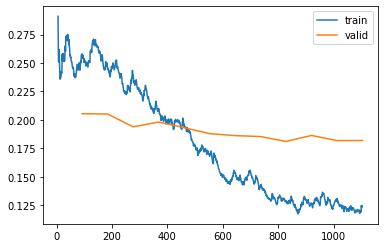

In [0]:
learn.recorder.plot_loss()

### Selecting the number of epochs

### Deeper architectures

In [0]:
from fastai2.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

epoch,train_loss,valid_loss,error_rate,time
0,1.427505,0.310554,0.098782,00:21
1,0.606785,0.302325,0.094723,00:22
2,0.409267,0.294803,0.091340,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.261121,0.274507,0.083897,00:26
1,0.296653,0.318649,0.084574,00:26
2,0.242356,0.253677,0.069012,00:26
3,0.150684,0.251438,0.065629,00:26
4,0.094997,0.239772,0.064276,00:26
5,0.061144,0.228082,0.054804,00:26


## Summary

## Questionnaire

1. Why do we first resize to a large size on the CPU, and then to a smaller size on the GPU?
1. If you are not familiar with regular expressions, find a regular expression tutorial, and some problem sets, and complete them. Have a look on the book website for suggestions.
1. What are the two ways in which data is most commonly provided, for most deep learning datasets?
1. Look up the documentation for `L` and try using a few of the new methods is that it adds.
1. Look up the documentation for the Python pathlib module and try using a few methods of the Path class.
1. Give two examples of ways that image transformations can degrade the quality of the data.
1. What method does fastai provide to view the data in a DataLoader?
1. What method does fastai provide to help you debug a DataBlock?
1. Should you hold off on training a model until you have thoroughly cleaned your data?
1. What are the two pieces that are combined into cross entropy loss in PyTorch?
1. What are the two properties of activations that softmax ensures? Why is this important?
1. When might you want your activations to not have these two properties?
1. Calculate the "exp" and "softmax" columns of <<bear_softmax>> yourself (i.e. in a spreadsheet, with a calculator, or in a notebook).
1. Why can't we use torch.where to create a loss function for datasets where our label can have more than two categories?
1. What is the value of log(-2)? Why?
1. What are two good rules of thumb for picking a learning rate from the learning rate finder?
1. What two steps does the fine_tune method do?
1. In Jupyter notebook, how do you get the source code for a method or function?
1. What are discriminative learning rates?
1. How is a Python slice object interpreted when past as a learning rate to fastai?
1. Why is early stopping a poor choice when using one cycle training?
1. What is the difference between resnet 50 and resnet101?
1. What does to_fp16 do?

### Further research

1. Find the paper by Leslie Smith that introduced the learning rate finder, and read it.
1. See if you can improve the accuracy of the classifier in this chapter. What's the best accuracy you can achieve? Have a look on the forums and book website to see what other students have achieved with this dataset, and how they did it.